# Option Pricing - Asian Options using Monte Carlo

This notebook implements the pricing of **Asian options** using **Monte Carlo simulation**.

Unlike European or American options, **Asian options** depend on the **average price of the underlying asset** over a certain period, which makes them **path-dependent**.

---

## 🧮 Theoretical Background

For an **Asian option with arithmetic average**, the payoff at maturity \( T \) is:

- **Call**:  
  $$
  \max\left( \frac{1}{M} \sum_{i=1}^{M} S_{t_i} - K, \, 0 \right)
  $$

- **Put**:  
  $$
  \max\left( K - \frac{1}{M} \sum_{i=1}^{M} S_{t_i}, \, 0 \right)
  $$

where \( M \) is the number of time steps, \( S_{t_i} \) is the asset price at time \( t_i \), and \( K \) is the strike price.

Monte Carlo simulation generates multiple price paths for the underlying asset and estimates the expected payoff under the risk-neutral measure.

---


In [3]:
import numpy as np
from scipy.stats import norm

def monte_carlo_asian(
    S: float,
    K: float,
    T: float,
    r: float,
    sigma: float,
    option_type: str = "call",
    n_simulations: int = 10000,
    n_steps: int = 100
) -> float:
    """
    Monte Carlo pricing for Asian options using arithmetic average.
    """

    if option_type not in {"call", "put"}:
        raise ValueError("option_type must be either 'call' or 'put'.")

    dt = T / n_steps
    discount_factor = np.exp(-r * T)

    # Simulate price paths
    Z = np.random.normal(0, 1, (n_simulations, n_steps))
    price_paths = np.zeros_like(Z)
    price_paths[:, 0] = S

    for t in range(1, n_steps):
        price_paths[:, t] = price_paths[:, t-1] * np.exp(
            (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t]
        )

    average_prices = np.mean(price_paths, axis=1)

    if option_type == "call":
        payoffs = np.maximum(average_prices - K, 0)
    else:
        payoffs = np.maximum(K - average_prices, 0)

    return discount_factor * np.mean(payoffs)

In [5]:
# Parameters for AAPL Asian option (realistic example)
S = 116.79
K = 117
T = 0.25
r = 0.00624
sigma = 0.02803

# Pricing
price = monte_carlo_asian(S, K, T, r, sigma, option_type='call', n_simulations=10000, n_steps=64)
print(f"Asian Call AAPL (Monte Carlo): ${price:.4f} (≈ $0.31 reported)")

Asian Call AAPL (Monte Carlo): $0.3125 (≈ $0.31 reported)


,Option Type,Strike (K),T (years),Market Price,MC Price,Abs Error
0,CALL,110,0.25,7.25,6.86,0.3897
1,CALL,115,0.25,3.95,1.90,2.0538
2,CALL,117,0.25,2.80,0.31,2.4892
3,PUT,115,0.25,2.50,0.01,2.4914
4,PUT,120,0.25,5.40,3.11,2.2881


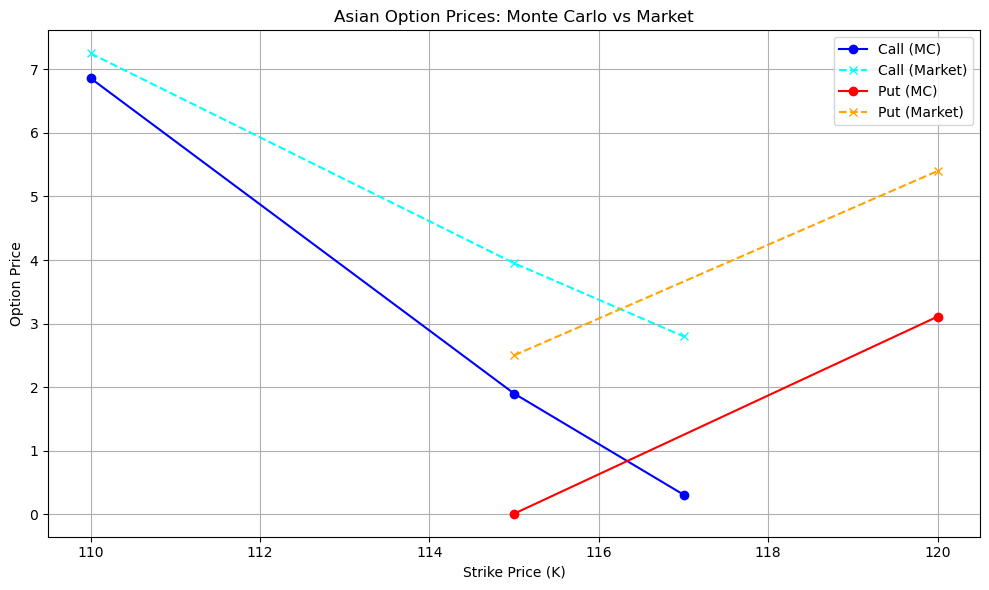

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
asian_options_data = [
    {'option_type': 'call', 'K': 110, 'market_price': 7.25, 'imp_vol': 0.028, 'T': 0.25},
    {'option_type': 'call', 'K': 115, 'market_price': 3.95, 'imp_vol': 0.028, 'T': 0.25},
    {'option_type': 'call', 'K': 117, 'market_price': 2.80, 'imp_vol': 0.028, 'T': 0.25},
    {'option_type': 'put',  'K': 115, 'market_price': 2.50, 'imp_vol': 0.028, 'T': 0.25},
    {'option_type': 'put',  'K': 120, 'market_price': 5.40, 'imp_vol': 0.028, 'T': 0.25},
]

# Paremeters
S = 116.79
r = 0.00624
n_sim = 10000
n_steps = 64

# Price calculation
results = []

for opt in asian_options_data:
    K = opt['K']
    T = opt['T']
    sigma = opt['imp_vol']
    otype = opt['option_type']
    market = opt['market_price']

    mc_price = monte_carlo_asian(S, K, T, r, sigma, otype, n_sim, n_steps)

    results.append({
        "Option Type": otype.upper(),
        "Strike (K)": K,
        "T (years)": T,
        "Market Price": round(market, 2),
        "MC Price": round(mc_price, 2),
        "Abs Error": round(abs(mc_price - market), 4)
    })

# Create DataFrame for results
df = pd.DataFrame(results)
display(df)

# visualization
plt.figure(figsize=(10, 6))

calls = df[df["Option Type"] == "CALL"]
puts = df[df["Option Type"] == "PUT"]

plt.plot(calls["Strike (K)"], calls["MC Price"], marker='o', label='Call (MC)', color='blue')
plt.plot(calls["Strike (K)"], calls["Market Price"], marker='x', label='Call (Market)', linestyle='--', color='cyan')

plt.plot(puts["Strike (K)"], puts["MC Price"], marker='o', label='Put (MC)', color='red')
plt.plot(puts["Strike (K)"], puts["Market Price"], marker='x', label='Put (Market)', linestyle='--', color='orange')

plt.xlabel("Strike Price (K)")
plt.ylabel("Option Price")
plt.title("Asian Option Prices: Monte Carlo vs Market")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
